# 🤖 Detector de Bots en Comentarios de TikTok

## Objetivo
Detectar comentarios sospechosos de ser generados por bots o trolls usando técnicas de Machine Learning no supervisado.

## Técnicas a utilizar:
1. **Extracción de Features**: texto, tiempo, embeddings, similitud
2. **Isolation Forest**: detecta anomalías por aislamiento
3. **DBSCAN**: detecta outliers como cluster -1
4. **Detección Combinada**: mayor confianza cuando ambos métodos coinciden

## Datos
Comentarios extraídos de TikTok relacionados a contenido político peruano.

In [2]:
# Librerías necesarias
import json
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y Embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Modelos de detección de anomalías
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 1. Carga de Datos

In [3]:
# Cargar comentarios
with open('comentarios_api_20260116_125926.json', 'r', encoding='utf-8') as f:
    comentarios = json.load(f)

# Convertir a DataFrame
df = pd.DataFrame(comentarios)

print(f"📊 Total de comentarios: {len(df)}")
print(f"\n📋 Columnas disponibles:")
print(df.columns.tolist())
print(f"\n🔍 Primeros 3 comentarios:")
df.head(3)

📊 Total de comentarios: 638

📋 Columnas disponibles:
['id', 'comment_id', 'text', 'likes', 'reply_count', 'create_time', 'user', 'timestamp', 'video_url']

🔍 Primeros 3 comentarios:


,id,comment_id,text,likes,reply_count,create_time,user,timestamp,video_url
0,1,,seamos más críticos al momento de elegir un ca...,0,0,0,"{'username': '', 'nickname': '', 'verified': F...",2026-01-16T12:59:06.638123,https://www.tiktok.com/@piuraesrenovacion/vide...
1,2,,Creo que para ser un gran líder y amar a tu pr...,0,0,0,"{'username': '', 'nickname': '', 'verified': F...",2026-01-16T12:59:06.638439,https://www.tiktok.com/@piuraesrenovacion/vide...
2,3,,Para mí es el mejor apuesto por el por su cono...,0,0,0,"{'username': '', 'nickname': '', 'verified': F...",2026-01-16T12:59:06.638445,https://www.tiktok.com/@piuraesrenovacion/vide...


In [4]:
# Exploración básica de los datos
print("📈 Estadísticas básicas:")
print(f"- Comentarios únicos: {df['text'].nunique()}")
print(f"- Videos únicos: {df['video_url'].nunique()}")

# Extraer info del usuario
df['username'] = df['user'].apply(lambda x: x.get('username', '') if isinstance(x, dict) else '')
df['nickname'] = df['user'].apply(lambda x: x.get('nickname', '') if isinstance(x, dict) else '')
df['verified'] = df['user'].apply(lambda x: x.get('verified', False) if isinstance(x, dict) else False)

print(f"- Usuarios únicos (por username): {df['username'].nunique()}")
print(f"- Usuarios verificados: {df['verified'].sum()}")

# Ver distribución de longitud de comentarios
df['text_length'] = df['text'].str.len()
print(f"\n📝 Longitud de comentarios:")
print(df['text_length'].describe())

📈 Estadísticas básicas:
- Comentarios únicos: 508
- Videos únicos: 1
- Usuarios únicos (por username): 1
- Usuarios verificados: 0

📝 Longitud de comentarios:
count    638.000000
mean      62.416928
std       75.645533
min        0.000000
25%       16.000000
50%       37.500000
75%       83.000000
max      662.000000
Name: text_length, dtype: float64


## 2. Extracción de Features

Vamos a extraer características del texto que nos ayuden a identificar patrones de bots:
- **Features de texto**: longitud, número de palabras, emojis, signos de puntuación
- **Features temporales**: timestamp de extracción
- **Embeddings TF-IDF**: representación vectorial del texto
- **Similitud**: qué tan parecido es un comentario a otros

In [5]:
import re

# === FEATURES DE TEXTO ===

# Longitud ya la tenemos (text_length)

# Número de palabras
df['word_count'] = df['text'].str.split().str.len().fillna(0)

# Número de emojis (patrón básico para emojis)
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)

df['emoji_count'] = df['text'].apply(lambda x: len(emoji_pattern.findall(str(x))))

# Signos de exclamación e interrogación
df['exclamation_count'] = df['text'].str.count('!')
df['question_count'] = df['text'].str.count(r'\?')

# Mayúsculas (proporción)
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1))

# Menciones (@)
df['mention_count'] = df['text'].str.count('@')

# Hashtags (#)
df['hashtag_count'] = df['text'].str.count('#')

# Comentarios duplicados (flag)
df['is_duplicate'] = df.duplicated(subset=['text'], keep=False).astype(int)

print("✅ Features de texto extraídas")
print(f"\nFeatures creadas: {['text_length', 'word_count', 'emoji_count', 'exclamation_count', 'question_count', 'caps_ratio', 'mention_count', 'hashtag_count', 'is_duplicate']}")
df[['text', 'text_length', 'word_count', 'emoji_count', 'caps_ratio', 'is_duplicate']].head(10)

✅ Features de texto extraídas

Features creadas: ['text_length', 'word_count', 'emoji_count', 'exclamation_count', 'question_count', 'caps_ratio', 'mention_count', 'hashtag_count', 'is_duplicate']


,text,text_length,word_count,emoji_count,caps_ratio,is_duplicate
0,seamos más críticos al momento de elegir un ca...,273,51,2,0.007326,0
1,Creo que para ser un gran líder y amar a tu pr...,320,60,0,0.037500,0
2,Para mí es el mejor apuesto por el por su cono...,242,43,1,0.008264,0
3,moliendo azúcar 12000 mil dólares.. 🤣😂😂.. voy ...,179,32,1,0.000000,0
4,Te admiro mucho señor Rafael usted es un ejemp...,83,15,0,0.024096,0
5,Es maravilloso escuchar el relato de su trayec...,178,32,0,0.016854,0
6,"La Udep es una universidad grande, profesores ...",221,40,0,0.027149,0
7,Su historia tiene muchos vacíos 🤨,33,6,0,0.030303,0
8,totalmente CIERTO sin perseverancia no logras ...,144,27,2,0.333333,0
9,te creo?,8,2,0,0.000000,0


In [6]:
# === EMBEDDINGS TF-IDF ===

# Crear vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=500,      # Limitar a 500 features más importantes
    stop_words=None,       # Mantener stopwords en español (no hay lista built-in)
    ngram_range=(1, 2),    # Unigramas y bigramas
    min_df=2               # Mínimo 2 documentos
)

# Filtrar textos vacíos
df['text_clean'] = df['text'].fillna('').astype(str)

# Crear matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['text_clean'])

print(f"✅ Matriz TF-IDF creada")
print(f"   Shape: {tfidf_matrix.shape}")
print(f"   Features (vocabulario): {len(tfidf.get_feature_names_out())}")
print(f"\n📝 Top 20 términos más frecuentes:")
feature_names = tfidf.get_feature_names_out()
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[-20:][::-1]
for i in top_indices:
    print(f"   - '{feature_names[i]}': {tfidf_sum[i]:.2f}")

✅ Matriz TF-IDF creada
   Shape: (638, 500)
   Features (vocabulario): 500

📝 Top 20 términos más frecuentes:
   - 'presidente': 38.88
   - 'porky': 29.89
   - 'de': 27.83
   - 'que': 24.56
   - 'el': 23.86
   - 'rafael': 23.50
   - 'la': 21.80
   - 'no': 19.27
   - 'es': 19.08
   - 'porky presidente': 18.98
   - 'lo': 17.73
   - 'en': 17.55
   - 'aliaga': 14.86
   - 'se': 14.66
   - 'un': 14.61
   - 'los': 14.33
   - 'del': 14.15
   - 'perú': 13.91
   - 'para': 13.41
   - 'con': 13.31


In [7]:
# === SIMILITUD ENTRE COMENTARIOS ===

# Calcular matriz de similitud coseno
similarity_matrix = cosine_similarity(tfidf_matrix)

# Para cada comentario, calcular su similitud promedio y máxima con otros
# (excluyendo la similitud consigo mismo que es 1.0)

n = len(df)
avg_similarity = []
max_similarity = []

for i in range(n):
    # Obtener similitudes con todos excepto consigo mismo
    sims = np.concatenate([similarity_matrix[i, :i], similarity_matrix[i, i+1:]])
    if len(sims) > 0:
        avg_similarity.append(sims.mean())
        max_similarity.append(sims.max())
    else:
        avg_similarity.append(0)
        max_similarity.append(0)

df['avg_similarity'] = avg_similarity
df['max_similarity'] = max_similarity

print("✅ Similitud calculada")
print(f"\n📊 Estadísticas de similitud:")
print(f"   Similitud promedio: {df['avg_similarity'].mean():.4f}")
print(f"   Similitud máxima promedio: {df['max_similarity'].mean():.4f}")

# Comentarios muy similares a otros (potenciales bots)
high_sim_threshold = 0.7
high_sim_comments = df[df['max_similarity'] > high_sim_threshold]
print(f"\n⚠️ Comentarios con similitud > {high_sim_threshold}: {len(high_sim_comments)}")

if len(high_sim_comments) > 0:
    print("\nEjemplos de comentarios muy similares:")
    for idx, row in high_sim_comments.head(3).iterrows():
        print(f"   - [{row['max_similarity']:.2f}] \"{row['text'][:80]}...\"" if len(row['text']) > 80 else f"   - [{row['max_similarity']:.2f}] \"{row['text']}\"")

✅ Similitud calculada

📊 Estadísticas de similitud:
   Similitud promedio: 0.0308
   Similitud máxima promedio: 0.5464

⚠️ Comentarios con similitud > 0.7: 229

Ejemplos de comentarios muy similares:
   - [1.00] "Porky presidente"
   - [0.75] "Rafael López Aliaga será el mejor presidente del Perú🇵🇪🇵🇪🇵🇪🩵🩵"
   - [1.00] "Mi futuro Presidente! 🫡"


## 3. Detección de Anomalías

### 3.1 Isolation Forest
Aísla observaciones seleccionando aleatoriamente una feature y un valor de corte. Las anomalías requieren menos cortes para ser aisladas.

In [8]:
# === PREPARAR FEATURES PARA LOS MODELOS ===

# Seleccionar features numéricas para el modelo
feature_columns = [
    'text_length',
    'word_count', 
    'emoji_count',
    'exclamation_count',
    'question_count',
    'caps_ratio',
    'mention_count',
    'hashtag_count',
    'is_duplicate',
    'avg_similarity',
    'max_similarity'
]

# Crear matriz de features
X = df[feature_columns].fillna(0).values

# Escalar features (importante para DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Features preparadas")
print(f"   Shape: {X_scaled.shape}")
print(f"   Features: {feature_columns}")

✅ Features preparadas
   Shape: (638, 11)
   Features: ['text_length', 'word_count', 'emoji_count', 'exclamation_count', 'question_count', 'caps_ratio', 'mention_count', 'hashtag_count', 'is_duplicate', 'avg_similarity', 'max_similarity']


In [9]:
# === ISOLATION FOREST ===

# contamination = proporción esperada de anomalías (ajustable)
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.15,  # Esperamos ~15% de bots/anomalías
    random_state=42,
    n_jobs=-1
)

# Entrenar y predecir
# -1 = anomalía, 1 = normal
df['iso_forest_pred'] = iso_forest.fit_predict(X_scaled)
df['iso_forest_score'] = iso_forest.score_samples(X_scaled)

# Convertir a formato más intuitivo (1 = bot/anomalía, 0 = normal)
df['is_anomaly_iforest'] = (df['iso_forest_pred'] == -1).astype(int)

print("✅ Isolation Forest entrenado")
print(f"\n📊 Resultados:")
print(f"   Anomalías detectadas: {df['is_anomaly_iforest'].sum()} ({df['is_anomaly_iforest'].mean()*100:.1f}%)")
print(f"   Normales: {(df['is_anomaly_iforest'] == 0).sum()}")

# Ver ejemplos de anomalías
print(f"\n🔍 Ejemplos de comentarios detectados como anomalías:")
anomalies_if = df[df['is_anomaly_iforest'] == 1].nsmallest(5, 'iso_forest_score')
for idx, row in anomalies_if.iterrows():
    text_preview = row['text'][:70] + "..." if len(row['text']) > 70 else row['text']
    print(f"   [{row['iso_forest_score']:.3f}] \"{text_preview}\"")

✅ Isolation Forest entrenado

📊 Resultados:
   Anomalías detectadas: 96 (15.0%)
   Normales: 542

🔍 Ejemplos de comentarios detectados como anomalías:
   [-0.707] "VIVA LOS RIOS DE AMOR!! PORKY PROXIMO PRESIDENTE DEL PERÚ 2026 !!🩵🩵🩵🩵🩵..."
   [-0.707] "VIVA LOS RIOS DE AMOR!! PORKY PROXIMO PRESIDENTE DEL PERÚ 2026 !!🩵🩵🩵🩵🩵..."
   [-0.695] "...@........HERJSIL es una startup que democratiza el acceso a oportun..."
   [-0.682] "PORKI VOTARÉ PIR PORKI???
PORKI NO ES RATERO!!!
LEI TAMBIÉN SU "HOJA D..."
   [-0.678] "Ser perseverante no es igual a ser inteligente, aunque muchos no disti..."


### 3.2 DBSCAN
Agrupa puntos densos y marca como outliers (cluster -1) los puntos que no pertenecen a ningún cluster.

In [10]:
# === DBSCAN ===

dbscan = DBSCAN(
    eps=1.5,           # Radio máximo entre puntos del mismo cluster
    min_samples=5,     # Mínimo de vecinos para formar cluster
    n_jobs=-1
)

df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
df['is_anomaly_dbscan'] = (df['dbscan_cluster'] == -1).astype(int)

print("✅ DBSCAN entrenado")
print(f"\n📊 Resultados:")
print(f"   Clusters encontrados: {df['dbscan_cluster'].nunique() - 1}")
print(f"   Outliers (cluster -1): {df['is_anomaly_dbscan'].sum()} ({df['is_anomaly_dbscan'].mean()*100:.1f}%)")

print(f"\n📈 Distribución de clusters:")
for cluster, count in df['dbscan_cluster'].value_counts().sort_index().items():
    label = "OUTLIERS" if cluster == -1 else f"Cluster {cluster}"
    print(f"   {label}: {count}")

✅ DBSCAN entrenado

📊 Resultados:
   Clusters encontrados: 12
   Outliers (cluster -1): 83 (13.0%)

📈 Distribución de clusters:
   OUTLIERS: 83
   Cluster 0: 244
   Cluster 1: 11
   Cluster 2: 83
   Cluster 3: 75
   Cluster 4: 25
   Cluster 5: 9
   Cluster 6: 5
   Cluster 7: 30
   Cluster 8: 12
   Cluster 9: 10
   Cluster 10: 48
   Cluster 11: 3


## 4. Detección Combinada

Mayor confianza cuando **ambos métodos coinciden**.

In [11]:
# === DETECCIÓN COMBINADA ===

# Calcular score combinado
df['bot_score'] = df['is_anomaly_iforest'] + df['is_anomaly_dbscan']

# Clasificación final
def classify_bot(row):
    if row['bot_score'] == 2:
        return 'Alta sospecha (ambos)'
    elif row['bot_score'] == 1:
        return 'Sospecha media (uno)'
    else:
        return 'Normal'

df['bot_classification'] = df.apply(classify_bot, axis=1)

print("✅ Detección combinada completada")
print(f"\n📊 RESULTADOS FINALES:")
print(df['bot_classification'].value_counts())

# Resumen
alta = (df['bot_score'] == 2).sum()
media = (df['bot_score'] == 1).sum()
normal = (df['bot_score'] == 0).sum()

print(f"\n🎯 Resumen:")
print(f"   🔴 Alta sospecha: {alta} ({alta/len(df)*100:.1f}%)")
print(f"   🟡 Sospecha media: {media} ({media/len(df)*100:.1f}%)")
print(f"   🟢 Normales: {normal} ({normal/len(df)*100:.1f}%)")

✅ Detección combinada completada

📊 RESULTADOS FINALES:
bot_classification
Normal                   528
Alta sospecha (ambos)     69
Sospecha media (uno)      41
Name: count, dtype: int64

🎯 Resumen:
   🔴 Alta sospecha: 69 (10.8%)
   🟡 Sospecha media: 41 (6.4%)
   🟢 Normales: 528 (82.8%)


In [12]:
# === VER COMENTARIOS SOSPECHOSOS ===

print("🔴 ALTA SOSPECHA (detectados por ambos métodos):\n")
high_suspect = df[df['bot_score'] == 2][['text', 'max_similarity', 'is_duplicate']].head(15)
for idx, row in high_suspect.iterrows():
    dup = "📋 DUP" if row['is_duplicate'] else ""
    sim = f"sim:{row['max_similarity']:.2f}"
    text = row['text'][:80] + "..." if len(str(row['text'])) > 80 else row['text']
    print(f"  [{sim}] {dup} {text}")

🔴 ALTA SOSPECHA (detectados por ambos métodos):

  [sim:0.38]  seamos más críticos al momento de elegir un candidato, pensemos en el Perú como ...
  [sim:0.41]  totalmente CIERTO sin perseverancia no logras NADA 😐 el HAMBRE Y LA NECESIDAD es...
  [sim:0.38]  La envidia, la maldad, el egoísmo existe.
Pero usted tranquilo señor Rafael Lópe...
  [sim:0.37]  RAFAEL ESTÁS PTEPARADO PARA SER PRESIDENTE EN EL PERÚ.
ESTAS MIY CAPACITADO.
TIE...
  [sim:0.44]  ALGUIEN QUE LOGRA ....LO QUE SE PROPONE!!....RAFAEL LOPEZ ALIAGA PRESIDENTE DEL ...
  [sim:0.49]  HISTORIA DE VIDA REAL! SABE COMOSALIR ADELANTE CON PERSEVERANCIA!!PORKI PRESIDEN...
  [sim:0.34]  Perú con RLA: Meritocracia motivadora para jóvenes y mayores, así como criterio ...
  [sim:0.34]  Con dos carreras profesionales, y mucho esfuerzo!!! hoy es un empresario exitoso...
  [sim:0.65]  @PERÚ:Mi primera votación será para Rafael López Aliaga, VAMOS PORKY 💙🇵🇪🌊 !
  [sim:0.40]  bendiciones 🦋❤❤ alcalde mi corazón confía en usted ❤❤ será un b

## 5. Visualización

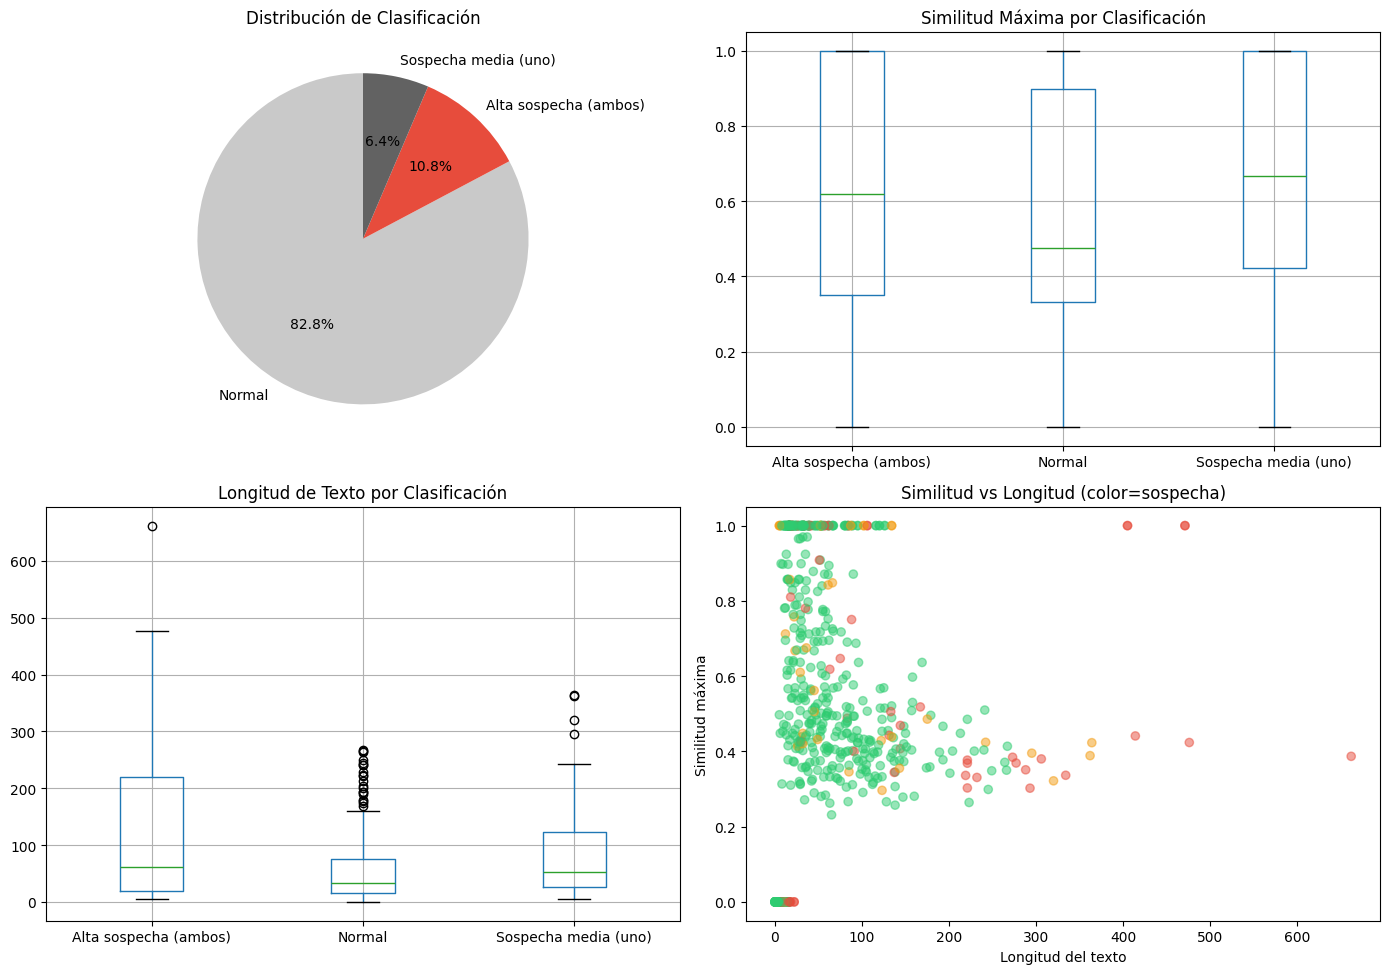

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de clasificación
colors = ["#c9c9c9", "#e74c3c", "#626262"]
df['bot_classification'].value_counts().plot(kind='pie', ax=axes[0,0], 
    colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribución de Clasificación')
axes[0,0].set_ylabel('')

# 2. Similitud máxima por clasificación
df.boxplot(column='max_similarity', by='bot_classification', ax=axes[0,1])
axes[0,1].set_title('Similitud Máxima por Clasificación')
axes[0,1].set_xlabel('')
plt.suptitle('')

# 3. Longitud de texto por clasificación
df.boxplot(column='text_length', by='bot_classification', ax=axes[1,0])
axes[1,0].set_title('Longitud de Texto por Clasificación')
axes[1,0].set_xlabel('')
plt.suptitle('')

# 4. Scatter: Similitud vs Longitud
scatter_colors = df['bot_score'].map({0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'})
axes[1,1].scatter(df['text_length'], df['max_similarity'], c=scatter_colors, alpha=0.5)
axes[1,1].set_xlabel('Longitud del texto')
axes[1,1].set_ylabel('Similitud máxima')
axes[1,1].set_title('Similitud vs Longitud (color=sospecha)')

plt.tight_layout()
plt.show()

## 6. Exportar Resultados

In [14]:
# Exportar resultados a CSV
output_columns = ['id', 'text', 'bot_classification', 'bot_score', 
                  'is_anomaly_iforest', 'is_anomaly_dbscan', 
                  'max_similarity', 'is_duplicate', 'text_length']

df_export = df[output_columns].copy()
df_export.to_csv('resultados_bots_detectados.csv', index=False, encoding='utf-8')

print("✅ Resultados exportados a 'resultados_bots_detectados.csv'")
print(f"\n📊 Resumen final:")
print(df['bot_classification'].value_counts())

✅ Resultados exportados a 'resultados_bots_detectados.csv'

📊 Resumen final:
bot_classification
Normal                   528
Alta sospecha (ambos)     69
Sospecha media (uno)      41
Name: count, dtype: int64
